In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image

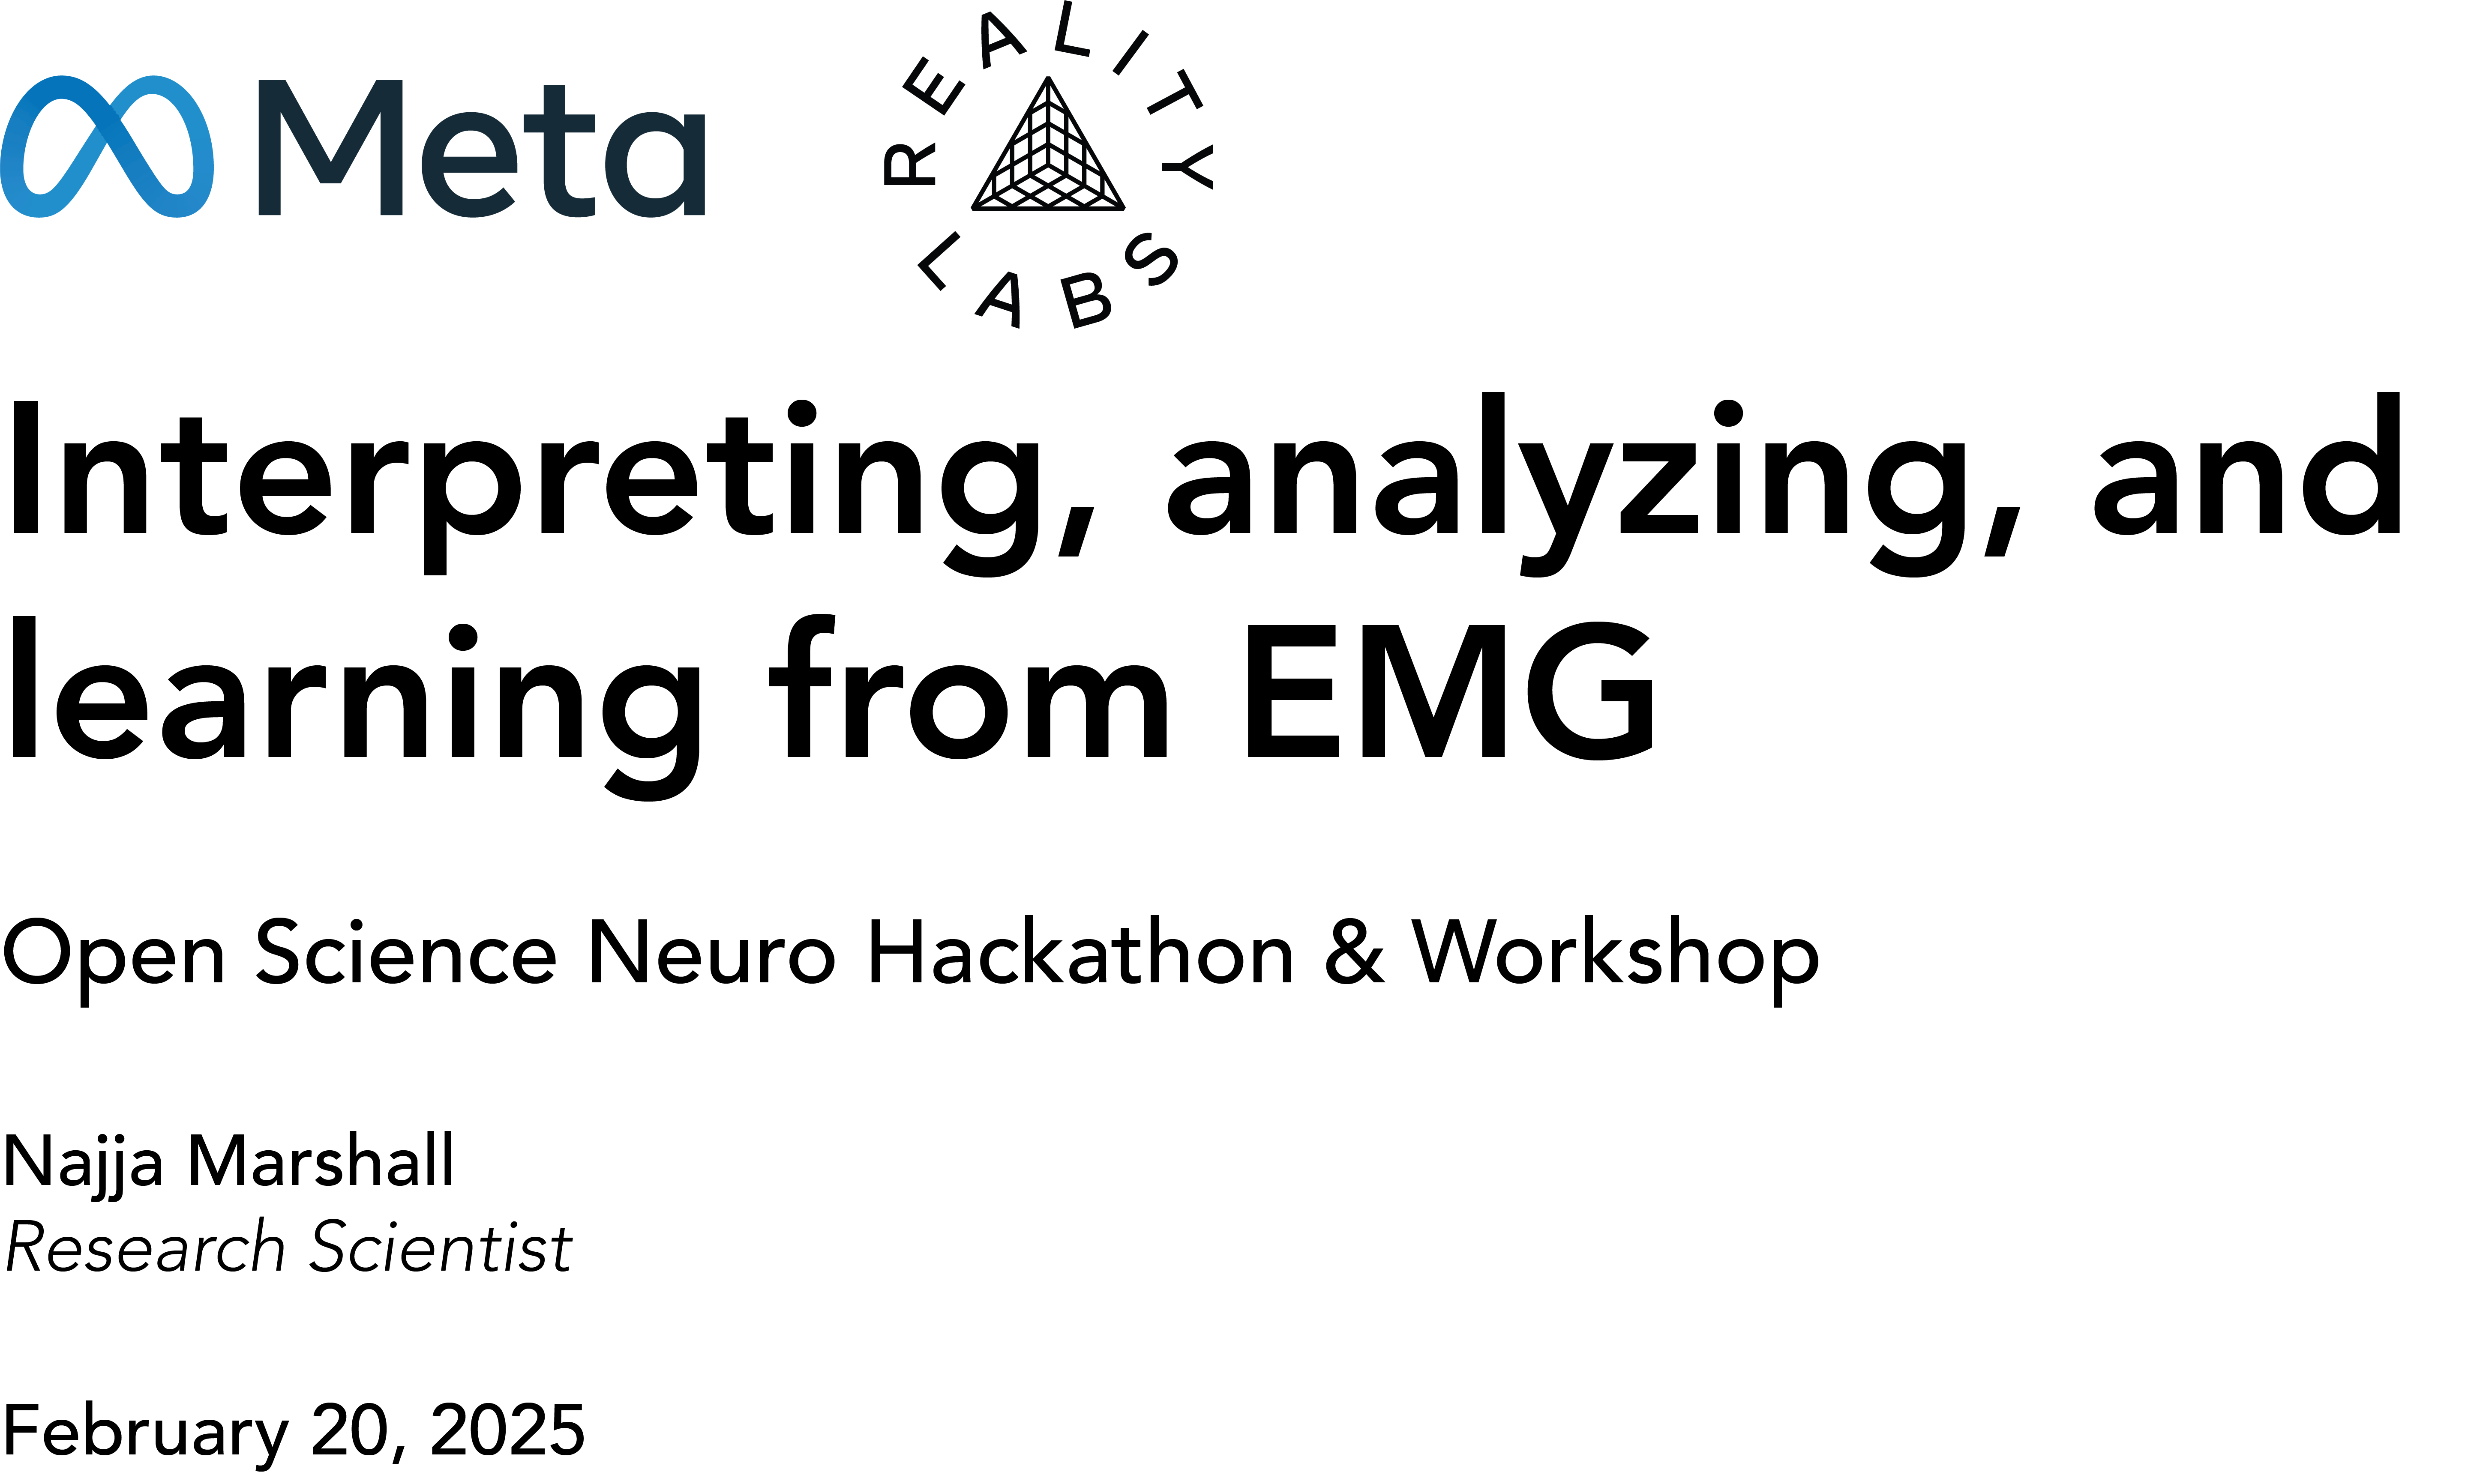

In [2]:
Image(filename="./header.png", width=1000)

#### Who are we?

The EMG Research Team at Meta aims to build an easy-to-use and reliable interface for interacting with the digital world. To achieve this, we’re building a high-resolution, noninvasive wristband that records muscle signals, or surface electromyography (sEMG), from the wrist. Our multi-disciplinary team of researchers investigates the nature of these signals and develops signal processing and machine learning methods to use sEMG for novel interactions and user experiences.

#### What is this tutorial about?

This tutorial covers three broad goals:
1. dig into what surface EMG signals typically look like, and how the signal features reflect underlying physiology
2. motivate and demonstrate the use of standard signal processing techniques to enable the extraction of behavioral information from the surface EMG signal
3. demonstrate the use of simple machine learning tools to extract this information

## 1. The data

### 1.1. Surface EMG

To this end, we will analyze some recently published EMG data from [Harshavardhana & Miller (2024)](https://iopscience.iop.org/article/10.1088/1741-2552/ad5107/). In this study, the authors collected surface EMG data using 12 electrodes placed around the wrist and around the forearm, as follows:

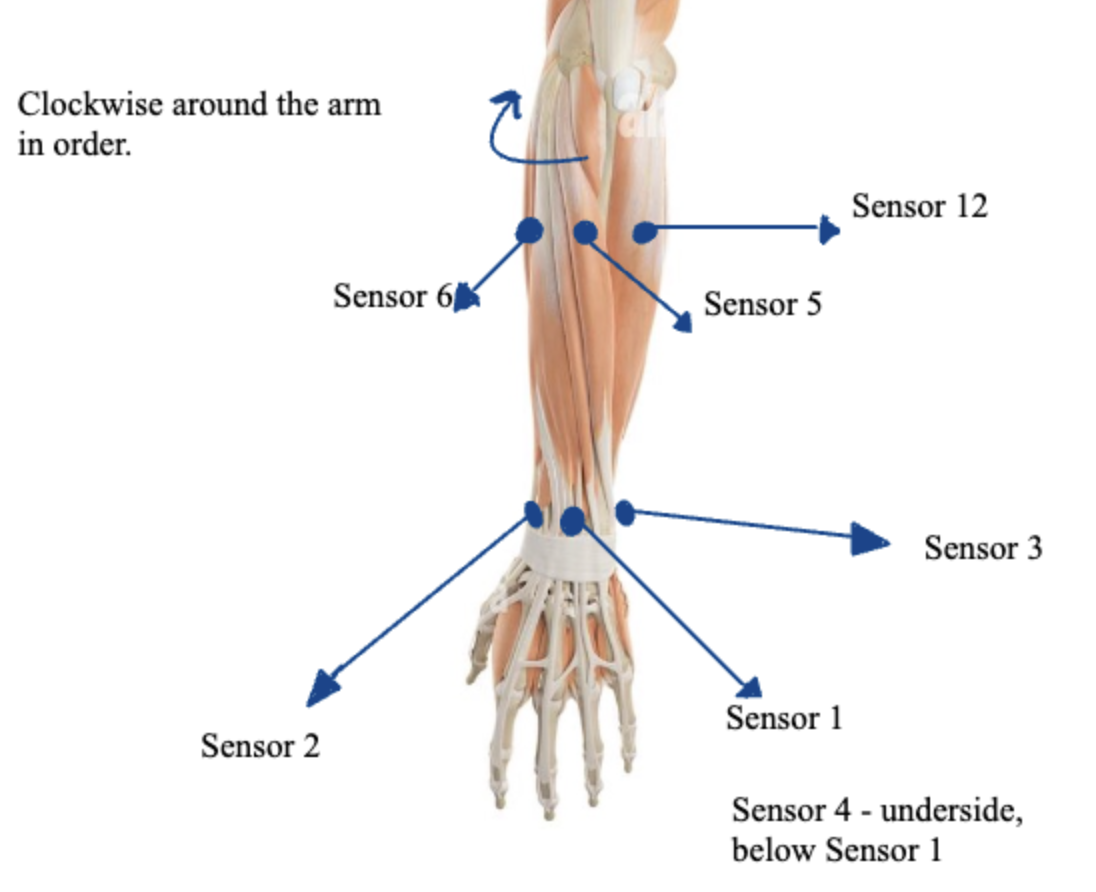

In [3]:
Image(filename="./electrodes.png", width=500)

We refer to each of these sensors as electrode 0, electrode 1, ..., electrode 11, using 0-based indexing to match the same indexing we use to index them in Python.

### 1.2. Behaviors

While EMG was recorded, subjects performed the following 10 hand gestures 36 times each, in a random order:

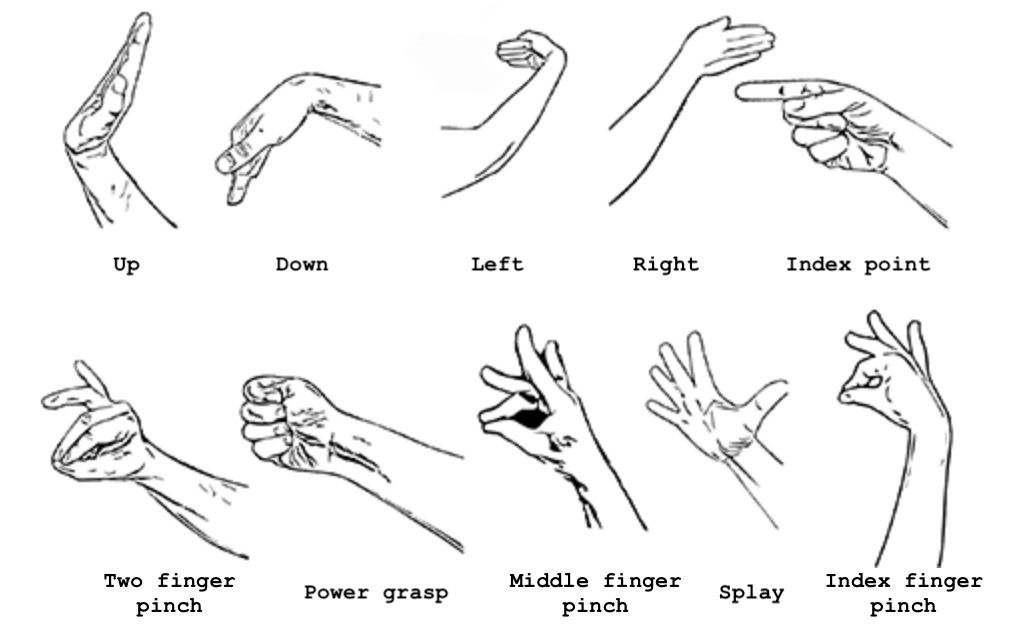

In [4]:
Image(filename="./gestures.png", width=800)

### 1.3. Our goal

Our goal in this tutorial is to build a *gesture decoder*, which automatically detects from the EMG signal which of these 10 gestures was performed by the subject. Such a decoder could be used for a neuromotor human-computer interface with 10 buttons in which you could "click" each of these buttons by simply producing the corresponding gesture, allowing the EMG sensors to detect your intent, rather than some physical button or controller.

Below, we will analyze the data from one subject from this experiment. We will dig into some of their data in detail to examine and understand the various sources of variability in EMG, and then try to use our insights to build and evaluate a simple gesture decoder.

### 1.4. Load and inspect data

In [5]:
"""Constants indicating where to load the data from
and the gesture names corresponding to each label
"""

URL = "https://osf.io/download/q7f4x/"
FILENAME = "data.npz"

GESTURE_NAMES = [
    "Down",
    "Index finger pinch",
    "Left",
    "Middle finger pinch",
    "Index point",
    "Power grasp",
    "Right",
    "Two finger pinch",
    "Up",
    "Splay",
]

In [6]:
"""Helper functions to load the data
"""

import requests

def download_data_from_url(url: str, filename: str) -> None:
    """Download data froma given URL to a local file"""
    try:
        r = requests.get(url)
        with open(filename, "wb") as fid:
            fid.write(r.content)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")

def load_data() -> tuple[np.ndarray, np.ndarray]:
    """Load a single dataset from OSF"""
    
    download_data_from_url(URL, FILENAME)
    data = np.load(FILENAME)
    
    emg = data['DATA']
    emg = emg.transpose([0, 2, 1])  # transpose from [trials, electrodes, time] -> [trials, time, electrodes]
    
    labels = data['LABELS']
    labels = labels.astype(int)
    labels = np.array(GESTURE_NAMES)[labels]  # get gesture name corresponding to each integer label
    
    return emg, labels

We load the data into two variables, called `emg` and `labels`:

In [ ]:
emg, labels = load_data()

We first inspect the `emg` array by printing its shape:

In [ ]:
num_trials, num_samples, num_electrodes = emg.shape

print(f"emg shape: {num_trials} trials x {num_samples} samples x {num_electrodes} electrodes")

This variable contains 360 trials, each with 4000 samples of EMG (2 seconds at 2000Hz sampling rate), from each of the 12 electrodes. Each one of these sequences corresponds to a different trial in which the subject was instructed to perform one of the 10 gestures.

Which gesture was produced in each trial is given by the `labels` array, which contains 360 strings indicating the gesture produced in each of the 360 trials:

In [ ]:
print("labels shape: ", labels.shape)
print("labels values: ", set(labels))

## 2. Visualize the raw EMG signal

Next, we'll pick a few of these trials and visualize the raw EMG signal. We'll try to relate the structure we see to the principles of EMG that were discussed in the lecture, in particular its composition in terms of motor unit action potentials.

In [ ]:
"""Helper functions for plotting
"""

from matplotlib.colors import Colormap

EMG_SAMPLING_RATE_HZ = 2000  # see paper

def plot_stacked_signals(
    stacked_signals: np.ndarray,
    xaxis: np.ndarray | None = None,
    labels_prefix: str | None = None,
    cmap: str | Colormap = "gist_rainbow",
    spacing: float = 0.3,
    yticks: bool = False,
    ax: plt.Axes | None = None,
    **kwargs,
):
    ax = ax or plt.gca()

    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)

    num_signals, _ = stacked_signals.shape

    if labels_prefix is None:
        labels = [None,] * num_signals
    else:
        labels = [f"{labels_prefix} {i}" for i in range(num_signals)]
    
    for i, (x, label) in enumerate(zip(stacked_signals, labels)):
        ax.plot(
            np.arange(len(x)) if xaxis is None else xaxis,
            x + i * spacing,
            color=cmap(i / (num_signals - 1)),
            label=label,
            **kwargs
        )

    ax.set_yticks(np.arange(num_signals) * spacing)
    ax.grid(axis="y", which="major", color="0.75", zorder=-1)

    if yticks:
        ax.set_yticklabels(np.arange(num_signals))

    return ax

def plot_emg(
    emg: np.ndarray,
    cmap: str | Colormap = "gist_rainbow",
    spacing: float = 0.3,
    sampling_rate: float = EMG_SAMPLING_RATE_HZ,
    ax: plt.Axes | None = None,
    **kwargs,
):
    num_electrodes, num_tsteps = emg.shape
    time = np.arange(num_tsteps) / sampling_rate
    ax = plot_stacked_signals(
        emg,
        xaxis=time,
        labels_prefix="electrode",
        cmap=cmap,
        spacing=spacing,
        yticks=True,
        ax=ax,
        **kwargs
    )
    sns.despine(ax=ax, left=True)
    ax.set_ylabel("EMG electrode")
    ax.set_xlabel("time (sec)")
    return ax

### 2.1. Inpsect raw EMG from one trial

Lets first pick one trial and visualize the raw EMG signal in that trial. We pick the first trial of the "Splay" gesture, which is a sequence of 4000 EMG samples from 12 electrodes:

In [ ]:
def get_single_trial_emg(
    data: np.ndarray,
    labels: np.ndarray,
    gesture_label: str,
    trial_index: int,
) -> np.ndarray:
    gesture_trial_indices, = np.where(labels == gesture_label)
    return data[gesture_trial_indices[trial_index]]

gesture = "Splay"
trial = 0

single_trial_emg = get_single_trial_emg(emg, labels, gesture, trial)

print(f"grabbing EMG data from one trial of the {gesture} gesture")
print("\tdata shape:", single_trial_emg.shape)

Next, we visualize it by plotting the EMG from each electrode stacked vertically: we start with electrode 0 at the bottom up to electrode 11 at the top, and color each electrode's data differently for the sake of visualization

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_emg(single_trial_emg.T, ax=ax)

ylim = ax.get_ylim()
ax.set_ylim(ylim)

snippet_times = [1.2525, 1.5225, 1.8175]
snippet_length_sec = .015  # 15ms

for t in snippet_times:
    ax.fill_between(
        [t, t + snippet_length_sec],
        *ylim,
        color="0.8",
        zorder=-1,
    )

Our first observation is that there is relatively little change in the EMG signal at the beginning of the trial, but about at half way many electrodes start lighting up. That's probably because that's when the user actually started producing the gesture, so the **muscles became active and started generating electrical activity**, which the sensors on the surface are able to pick up on.

Our second observation is that this electrical activity is very "spiky": in some electrodes it appears like there are very sharp and fast deflections of the signal producing **rapid upward and downward peaks in activity**. A few of these are highlighted by the three gray shaded regions, which mark some prominant spikes in electrodes 9, 10, and 0, respectively, from left to right. These are **motor unit action potentials** being detected on the surface.

Below, we zoom in and plot the EMG within those three shaded areas to see what these waveforms look like in more detail:

In [ ]:
fig, axes = plt.subplots(
    1, len(snippet_times),
    figsize=(6, 4),
    sharex=False,
    sharey=True,
    gridspec_kw=dict(wspace=0.5),
)

for i, (t, ax) in enumerate(zip(snippet_times, axes)):
    plot_emg(single_trial_emg.T, ax=ax)
    ax.set_xlim([t, t + snippet_length_sec])
    ax.tick_params(axis="y", length=0)
    if i > 0:
        ax.set_ylabel(None)

Within this very shot timesapce of .015 sec = 15 ms, we see that only a few electrodes show significant activity. However, that activity tends to be **spatially localized**: activity is typically shared by neighboring electrodes, not randomly distributed along the electrodes. In the leftmost and middle examples, only electrodes 6-7 and 9-10 are highly active; in the rightmost example electrodes 0-3 and 9-10.

The reason for this is that the a single motor unit action potential within the muscular tissue **produces an electrical signal that emanates to a wider region of the skin** as it is conducted through the intervening biological tissue. It thus gets picked up on by the multiple EMG electrodes in that area. The more electrodes you have in that area, the better the picture you get of what that electrical signature looks like.

Note as well that, even though neighboring electrodes are typically active at the same time, **the shape of that activity can be quite different in each electrode**. For example, in the EMG snippet on the right we see that both electrode 0 and electrode 1 detect something at the same time, but that event manifests itself as a positive peak in electrode 1 and a negative peak in electrode 0.

The reason for this is that the electrical signature of the motor unit action potential can get distorted in different ways as it is conducted to the surface of the skin, depending on what tissue it has to traverse along the way. So even though the same motor unit action potential will typically be picked up by multiple nearby EMG electrodes, each of those electrodes may get a slightly different "view" of it depending on exactly where that electrode is placed on the skin relative to the motor unit's location beneath the skin.

### 2.2. Compare EMG evoked by different gestures

Next, let's zoom back out a bit and look at the EMG signal evoked by each gesture, and ask how it differs across gestures.

Below, we plot the first trial from each gesture to get a sense of this:

In [ ]:
fig, axes = plt.subplots(
    2, 5,
    figsize=(14, 6),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.3),
)

for gesture, ax in zip(GESTURE_NAMES, axes.ravel()):
    single_trial_emg = get_single_trial_emg(emg, labels, gesture, 0)
    plot_emg(single_trial_emg.T, linewidth=1, ax=ax)
    ax.set_title(gesture)

for ax in axes[:, 1:].ravel():
    ax.tick_params(axis="y", length=0)
    ax.set_ylabel(None)

We note a few observations:
* During periods of high activity, **the EMG signal is very "spiky"**, with rapid positive and negative deflections. This is the hallmark of many motor unit action potentials being detected by the electrodes.
* **_Which_ electrode are active differs between gestures**. For example, electrode 9 is highly active during the "Down" gesture, but almost completely silent during the "Index finger pinch" gesture
* **_How_ active each electrode is differs between gestures**. For example, electrode 10 is active during both the "Down" and "Power grasp" gestures, but significantly more so during the "Down" gesture
* **_When_ each electrode is active differs between gestures**. For example, during the "Down" gesture electrode 6 becomes briefly active at around the 0.75 sec mark and then becomes silent, whereas in the "Index finger pinch" gesture it remains active throughout.

### 2.3. Nuisance variables

Lets now go back and consider our goal of building an EMG-based gesture detector that can determine which EMG snippet was evoked by which gesture.

Such an algorithm would have to be able to do two things:
1. **detect** features of the EMG signal that differ between trials of _different_ gestures, such as those we noted above
2. **ignore** features of the signal that differ between trials of the _same_ gesture, so that these trials are still classified as the same gesture.

We call these latter features **nuisance variables**, since they are components of the signal that are unrelated to the information we want to extract from it; in other words, they're a nuisance.

### 2.4. Compare EMG evoked by different trials of the same gesture

To get some intuition for what the nuisance variables are in this problem, we visualize multiple trials of the same gesture. Below we plot the first 10 trials of the "Splay" gesture:

In [ ]:
emg.shape, labels.shape

In [ ]:
fig, axes = plt.subplots(
    2, 5,
    figsize=(14, 6),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(hspace=0.3),
)

gesture = "Splay"

for trial_index, ax in enumerate(axes.ravel()):
    single_trial_emg = get_single_trial_emg(emg, labels, gesture, trial_index)
    plot_emg(single_trial_emg.T, linewidth=1, ax=ax)
    ax.set_title(f"trial {trial_index}")

for ax in axes[:, 1:].ravel():
    ax.tick_params(axis="y", length=0)
    ax.set_ylabel(None)

First, note that electrodes 0-2, 6-7 and 9-10 are consistently active in all trials. That's good news: _which_ EMG electrodes are active is not just a feature that differs across trials from _different_ gestures, it is also a feature that remains mostly the same across trials of the _same_ gesture. This should therefore be a reliable feature to use for our gesture decoder.

A feature that does _not_ seem to be so reliable is the precise timing of the spikes we see in each electrode. Look, for example, a the spikes in electrode 10. We see that in almost every trial, spikes begin in this electrode at around the 1 sec mark. But after this point, how many spikes occur and precisely when they occur seems to vary quite a bit from trial to trial. To see this more clearly, below we plot the activity in electrode 10 in the first 7 trials:

In [ ]:
num_trials = 7
electrode_index = 10
spacing = 0.3

single_electrode_activity_per_trial = [
    get_single_trial_emg(emg, labels, gesture, trial_index)[:, electrode_index]
    for trial_index in range(num_trials)
]
single_electrode_activity_per_trial = np.stack(single_electrode_activity_per_trial)

fig, ax = plt.subplots(figsize=(8, 3))

plot_stacked_signals(
    single_electrode_activity_per_trial,
    xaxis=np.arange(emg.shape[1]) / EMG_SAMPLING_RATE_HZ,
    labels_prefix="trial",
    cmap="Dark2",
    spacing=spacing,
    linewidth=1,
    ax=ax
)

ax.set_yticks(np.arange(num_trials) * spacing)
ax.set_yticklabels(np.arange(num_trials))
sns.despine(ax=ax, left=True)
ax.set_xlabel("time (sec)")
ax.set_ylabel("trial")

ax.legend(bbox_to_anchor=(1, 1), frameon=False)

ax.set_title(f"{gesture} gesture, channel {electrode_index}");

In every one of these trials, spikes begin to appear in this electrode after about 1 second. But in each case we see a different number of spikes, and the spikes never occur at exactly the same times as in the other trials. Note also that the shapes of the spikes differ substantially from trial to trial: sometimes the spikes are smaller, sometimes they're bigger, sometimes big spikes follow small spikes, ...

These observations reveal the existence of a few nuisance variables:
* the spike count in each electrode
* millisecond-by-millisecond timing of spikes in each electrode
* shape of the spikes in each electrode

Why do these features vary so much from trial to trial? This is likely because, even though the same gesture is being executed on each trial, it may be executed in a slightly different way each time. For example, the subject might execute it faster, slower, harder, or softer on one trial than in another. Because behavior is directly controlled by motor units, these small differences in behavior correspond to differences in which motor units are activated when. This means that each trial contains different sequences of motor unit action potentials, which manifests itself in the surface EMG signal as differences in the motor unit action potential spikes picked up by each electrode.

## 3. Preprocessing EMG

Putting all of the above together, for our gesture decoder to tell apart _different_ gestures, it should be sensitive to:
* which electrodes are active
* how active each electrode is
* when each electrode is active, on a coarse second-by-second scale

On the other hand, for our gesture decoder to classify different trials of the _same_ gesture as the same gesture, it should be _in_sensitive to:
* how many spikes occur in each electrode
* when the spikes occur, on a fine millisecond-by-millisecond scale
* the shapes of each spike

To directly build these features into our gesture decoder, we will **preprocess** the EMG signal into a set of **EMG features** that have these properties baked in.

### 3.1. EMG signal power

Specifically, we will use what is sometimes called the root-mean-square (RMS) power of the EMG signal, which consists of the following two steps:
1. square the signal, thus making it all positive
2. average it over a medium-sized time window (we will use 250 ms)
3. take the square root

Steps 1 and 2 help remove the nuisance variables from the signal, since we remove all millisecond-level spike timing and spike shape information by averaging the signal over a 250ms time window. Note that the positive and negative deflections of the signal would cancel each other out in an average, so we make sure to square the signal first in order to keep information about which electrodes are active and how active they are. Finally, the square root simply helps to keep the signal within a reasonable range, since squaring numbers can sometimes make them too big or too small.

We also don't need to know what happens at every single 250 ms window in the trial, since the features we care about vary on a coarse second-by-second timescale. We therefore compute these RMS power features on successive 250 ms windows separated, or _strided_, by 50ms.

We call these **RMS power EMG features**.

In [ ]:
from collections.abc import Callable

def compute_strided_features(
    data: np.ndarray,
    feature_fn: Callable[[np.ndarray], np.ndarray],
    window_length: int,
    stride: int
) -> np.ndarray:
    features = []
    num_total_samples = data.shape[0]
    for i in range(0, num_total_samples - window_length, stride):
        window = data[i:(i + window_length)]
        features.append(feature_fn(window))
    features = np.stack(features)
    return features

In [ ]:
def compute_rms_power(data: np.ndarray) -> np.ndarray:
    squared_power = np.sum(data ** 2, axis=0)
    rms_power = np.sqrt(squared_power)
    return rms_power

rms_power_window_length = 500  # 0.25 sec @ 2000Hz
rms_power_stride = 100  # 0.05 sec @ 2000Hz

rms_power_features = np.stack([
    compute_strided_features(
        x,
        compute_rms_power,
        window_length=rms_power_window_length,
        stride=rms_power_stride,
    )
    for x in emg
])

Below, we plot the raw EMG from 5 trials and below each panel we plot the corresponding strided RMS power EMG features:

In [ ]:
gestures = ['Down', 'Left', 'Index point', 'Right', 'Splay']

fig, axes = plt.subplots(
    2, 5,
    figsize=(14, 6),
    sharex="row",
    sharey="row",
    gridspec_kw=dict(hspace=0.3),
)

for i, gesture in enumerate(gestures):
    
    ax = axes[0, i]
    raw_emg = get_single_trial_emg(emg, labels, gesture, 0)
    plot_emg(raw_emg.T, linewidth=1, ax=ax)

    ax = axes[1, i]
    emg_features = get_single_trial_emg(rms_power_features, labels, gesture, 0)
    plot_emg(
        emg_features.T,
        spacing=0.,
        sampling_rate=EMG_SAMPLING_RATE_HZ / rms_power_stride,
        linewidth=2,
        ax=ax
    )
    
    axes[0, i].set_title(gesture)

Note how the EMG signal power features do indeed show _which_ electrodes are active, _how_ active they are, and _when_ they are active, without being sensitive to the precise spike times and spike shapes.

### 3.2. Visualizing all trials with dimensionality reduction

The above plots are nice to see, to confirm our intuition that RMS power features bring forth differences between trials from different gestures. But it is hard to look at more than 5-10 trials at a time in this way. It would be ideal if we could look at _all_ the trials from _all_ the gestures. But we have 360 trials -- how can we visualize that many?

For this, we use **dimensionality reduction** to plot each trial as a single point in a two-dimensional space. We first "flatten" out the time and electrode dimensions into one axis, turning each of our `time x electrode` timeseries into a single `time * electrode`-dimensional vector, in which each dimension corresponds to the RMS power of one electrode at one time:

In [ ]:
print("RMS power feature timeseries shape: ", rms_power_features.shape)

rms_power_feature_vectors = rms_power_features.reshape(rms_power_features.shape[0], -1)

print("RMS power flattened feature vectors shape: ", rms_power_feature_vectors.shape)

We can then apply PCA to reduce the dimensionality from 420 to 2:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_projection = pca.fit_transform(X=rms_power_feature_vectors)

print("RMS power PCA projection shape: ", pca_projection.shape)

Below, we plot each of these dimensionality-reduced trials as a single point in PC1-PC2 space, colored by which gesture was executed in that trial:

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    x=pca_projection[:, 0],
    y=pca_projection[:, 1],
    hue=labels,
    ax=ax
)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

sns.despine(ax=ax)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

It is hard to see much structure here, mainly because of the presence of one strong outlier that has a very high projection along PC2. Because PCA just tries to capture as much variance as possible in the data, it is known to be sensitive to such outliers.

We therefore next try a different method called [t-SNE](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne), which is a non-linear dimensionality reduction technique that is typically less sensitive to outliers and very sensitive to cluster-like structure in the data. This is a very popular tool for dimensionality reduction, but somewhat less interpretable than PCA due to its higher complexity.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_projection = tsne.fit_transform(X=rms_power_feature_vectors)

print("RMS power t-SNE projection shape: ", tsne_projection.shape)

As we did with PCA above, below we plot the t-SNE projections of every trial, colored by gesture:

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    x=tsne_projection[:, 0],
    y=tsne_projection[:, 1],
    hue=labels,
    ax=ax
)
sns.despine(ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

Here we see a lot of very clear structure! Note that all the trials from a given gesture tend to cluster close together, and each gesture's cluster is overlaps little with the clusters of other gestures. This shows that our RMS power features are indeed sensitive to differences between gestures, while not being overly sensitive to differences between trials of the same gesture.

## 4. Classifying gestures from RMS power features

Now satisfied with our preprocessed EMG features, we finally move on to the last step of constructing our gesture decoder: machine learning.

### 4.1. Fit a logistic regression model

We will use the data available to use to train a simple linear classifier called a **[logistic regression model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#As_a_log-linear_model)**, which takes as input a trial of EMG data, $X$, and predicts the probability that that EMG signal was produced by each of the 10 gestures as follows:
$$
p(\text{single trial EMG data } X \text{ is gesture } k) = \frac{1}{Z} e^{\sum_{i=1}^N \sum_{t=1}^T w^{(k)}_{it} X_{it}}
$$
where $X_{it}$ is the RMS power in electrode $i$ at time $t$, $N$ is the total number of electrodes, $T$ is the total number of RMS power feature samples in each trial, and $K$ is the number of gestures. The exponentiation is to turn the weighted linear sum of EMG activity -- which can be negative or positive -- into a positive number to make it into a probability, and $Z$ is a normalization constant to make sure these probabilities are between 0 and 1 and sum to 1 (set to $Z = \sum_{k' = 1}^K e^{\sum_{i=1}^N \sum_{t=1}^T w^{(k')}_{it} X_{it}}$). The model's _weights_, $w^{(k)}_{it}$, are the parameters that we optimize to fit the data.

We first fit these in just a couple of lines of code using the `sklearn.linear_model.LogisticRegression` class:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    penalty=None,
    multi_class="multinomial",
    max_iter=2000,
)

model.fit(X=rms_power_feature_vectors, y=labels)

We then evaluate the fitted model by calculating the accuracy of its predictions, i.e. the percent of trials that whose gesture was correctly predicted:

In [ ]:
accuracy = model.score(X=rms_power_feature_vectors, y=labels)

print("accuracy: ", accuracy)

A perfect score! But this is hard to believe: there is noise in the data (e.g. that outlier in the PCA plot above) that should preclude us from being able to predict each gesture perfectly.

This suspiciously good result suggests that our model may have **overfit its training data**: it has learned to use very specific features of these data in order to make its predictions, but these features may not exist in new trials of EMG outside of these data. Note that, for this model to be useful as a gesture decoder in a neuromotor interface, we want it to work for executions of these gestures in real-life scenarios with a human-computer interface. Will the model actually correctly classify EMG data from new trials of these gestures? Or can it only correctly classify the 360 pre-recorded trials it was trained on?

### 4.2. Cross-validation

To assess this, we perform **cross-validation**: we remove a few trials from the data and, after fitting the model to the remaining data (which we call the **training set**), we use these held-out trials (which we call the **test set**) to assess whether the model can correctly classify trials outside of the training data:

In [ ]:
num_samples_to_hold_out = 10

X_test = rms_power_feature_vectors[:num_samples_to_hold_out]
y_test = labels[:num_samples_to_hold_out]

X_train = rms_power_feature_vectors[num_samples_to_hold_out:]
y_train = labels[num_samples_to_hold_out:]

model.fit(X=X_train, y=y_train)

print("train set accuracy:", model.score(X=X_train, y=y_train))
print("test set accuracy:", model.score(X=X_test, y=y_test))

We see that indeed, despite performing again perfectly on the train set, the model performs significantly worse on the held-out test set. This a clear sign that the model is overfitting its training data.

Is this a general property of this problem, or did we maybe get unlucky with some particularly difficult examples in the small test set? Before overreacting, let's first look closely at what the labels were in the test set:

In [ ]:
print(y_test)

Note that there were more of one `Middle finger pinch` and `Index finger pinch` in the test set, which means that there were fewer in the train set.

To correct for this and ensure that there are the same number of samples of each gesture in the train and test sets, we use the `StratifiedKFold` cross validation splitter from `sklearn`, which specifically enforces that each train/test **split** of the data contains even numbers of samples from each class in the train and test sets.

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=9,
    shuffle=True,
    random_state=24
)

The `.split` method of this class will produce `n_splits` train/test splits as follows:
1. split up the data into `n_splits` equally sized partitions
2. ensure that each partition contains the same number of samples from each class
3. produce `n_splits` train/test splits, in which each one a different one of the partitions is used as the test set and the remaining ones are put in the training set

We have set `n_splits=9`, so we will get 9 different train/test splits. We confirm below that each one of these splits contains even number of samples from each class:

In [ ]:
train_test_splits = cv.split(rms_power_feature_vectors, labels)

for split_num, (train_indices, test_indices) in enumerate(train_test_splits):
    classes, counts = np.unique(labels[train_indices], return_counts=True)
    print(f"split {split_num}:")
    print("\ttrain set contains following class counts:", counts)
    classes, counts = np.unique(labels[test_indices], return_counts=True)
    print("\ttest set contains following class counts:", counts)
    print("")

Now we can loop over each one of these train/test splits, evaluate the training score and test score, and see if the model is overfitting in every single case or whether the overfitting we saw above was more of an isolated incident due to the class imbalance:

In [ ]:
# assemble train/test sets in each split
train_test_splits = cv.split(rms_power_feature_vectors, labels)

# loop over train/test sets and calculate train/test score for each one

train_scores = []
test_scores = []

for train_inds, test_inds in train_test_splits:

    # get train set
    X_train = rms_power_feature_vectors[train_inds]
    y_train = labels[train_inds]

    # get test set
    X_test = rms_power_feature_vectors[test_inds]
    y_test = labels[test_inds]

    # fit model to train set
    model.fit(X=X_train, y=y_train)

    # assess model on test set
    train_score = model.score(X=X_train, y=y_train)
    train_scores.append(train_score)
    test_score = model.score(X=X_test, y=y_test)
    test_scores.append(test_score)

# take the mean over all train/test sets
train_score = np.mean(train_scores)
test_score = np.mean(test_scores)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.barplot(
    x=["train", "test"],
    y=[train_score, test_score],
    hue=["train", "test"],
    ax=ax,
)

for i, x in enumerate([train_score, test_score]):
    ax.annotate(
        f"{100 * x:.1f}%",
        (i, x - .02),
        ha="center",
        va="top",
        color="w",
    )

ax.set_ylim([0.5, 1.01])
ax.grid(axis="y", zorder=-1)
ax.set_axisbelow(True)

ax.set_xlabel("train/test split")
ax.set_ylabel("accuracy")

sns.despine(ax=ax)

We see that there remains a substantial **train/test gap**, although we're still getting a pretty good average accuracy of 89.7% on the held-out test sets. So maybe the overfitting is not as bad as we originally thought.

How can we reduce overfitting? One way to do this is to add a **regularization penalty** that penalizes large weights, thus restricting the weights to be small and restricting the model's capacity to overfit the training data. We can do this in sklearn by setting `penalty="l2"` and setting a small value for `C`, which is the inverse of the importance given to the regularization penalty. Here we use `C = 2.0`:

In [ ]:
model = LogisticRegression(
    penalty="l2",
    C=3.0,
    multi_class="multinomial",
    max_iter=5000,
)

To take care of the cross-validation loop we implemented above, we use the function `cross_validate`, which essentially does exactly the same thing, and returns the train and test scores for each split:

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    model,
    X=rms_power_feature_vectors,
    y=labels,
    cv=cv,
    return_train_score=True,
)

train_score = np.mean(scores["train_score"])
test_score = np.mean(scores["test_score"])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.barplot(
    x=["train", "test"],
    y=[train_score, test_score],
    hue=["train", "test"],
    ax=ax,
)

for i, x in enumerate([train_score, test_score]):
    ax.annotate(
        f"{100 * x:.1f}%",
        (i, x - .02),
        ha="center",
        va="top",
        color="w",
    )

ax.set_ylim([0.5, 1.01])
ax.grid(axis="y", zorder=-1)
ax.set_axisbelow(True)

ax.set_xlabel("train/test split")
ax.set_ylabel("accuracy")

sns.despine(ax=ax)

Our test set performance has now improved by about 2%. The regularization penalty seems to have indeed improved the model's ability to classify gestures outside of the training set. Note that the train score has gone down by about 3%, also because of the regularization. But that doesn't matter: the important thing is that the test score has risen, as this is what matters for a gesture decoder to be useable in real life situations, which are outside of the training set!

### 4.4. Examining model confusions

Unfortunately the gesture decoder still is not perfect, as it gets about 9% of its predictions wrong. For the purposes of deploying this gesture decoder for an human-computer interface, it would be useful to know whether the mistakes it makes are more common for some gestures for others. For example, 
* maybe it gets "Down" right every time, but makes more mistakes with the "Up" gesture. In this case, we might want to remove the "Up" gesture entirely to avoid mistakes when using the interface.
* another possibility is that maybe "Down" and "Left" are confused often, since they involve similar deflections of the wrist. In that case, we might want to combine these two gestures into one gesture, which might be correctly classified more often

To investigate these possibilities, we compute the **confusion matrix**, which shows what percentage of the time each gesture is confused with another gesture:

In [ ]:
"""Function to evaluate confusion matrix on
held-out test sets from cross-validation splits
"""

import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.model_selection import BaseCrossValidator

def compute_confusion_matrix(
    data: np.ndarray,
    labels: np.ndarray,
    model: BaseEstimator,
    cv: BaseCrossValidator,
) -> tuple[np.ndarray, np.ndarray]:
        
    # assemble train/test splits
    train_test_splits = cv.split(data, labels)
    
    # loop over train/test splits and compute test set predictions in each case
    
    y_pred = []
    y_true = []
    
    for train_inds, test_inds in train_test_splits:
    
        # assemble train set
        X_train = data[train_inds]
        y_train = labels[train_inds]
    
        # assemble test set
        X_test = data[test_inds]
        y_test = labels[test_inds]
    
        # fit model to train set
        model.fit(X=X_train, y=y_train)
    
        # compute model predictions on test set
        y_pred.append(model.predict(X=X_test))
    
        # grab test set true labels
        y_true.append(y_test)
    
    # aggregate predictions and true labels from all test
    # sets into a single numpy array
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    # compute confusion matrix over all predictions
    cmat = confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        labels=GESTURE_NAMES,
        normalize="true",
    )

    # assemble confusion matrix into a dataframe with gesture names
    cmat = pd.DataFrame(
        cmat,
        index=GESTURE_NAMES,
        columns=GESTURE_NAMES,
    )

    return cmat

In [ ]:
rms_power_confusion_matrix = compute_confusion_matrix(
    data=rms_power_feature_vectors,
    labels=labels,
    model=model,
    cv=cv,
)

In [ ]:
import pandas as pd

fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.heatmap(
    np.around(rms_power_confusion_matrix, decimals=2),
    vmin=0.,
    vmax=1.,
    cmap="Reds",
    ax=ax,
    annot=True,
    annot_kws=dict(fontsize=10),
)

ax.set_xlabel("predicted gesture");
ax.set_ylabel("true label");

Each row of this matrix shows the percentage of times that a given gesture was classified as another gesture.

For example, if we look at the fourth row, we see that actually only 83% of "Middle finger pinch" trials are classified correctly as "Middle finger pinch", with the remaining 17% being confused with "Two finger pinch". This is not too surprising, since these two gestures are quite similar in that they both involve squeezing your middle finger and thumb together: 

In [ ]:
Image(filename="./pinches.png", width=500)

For the same reason, the "Two finger pinch" gesture gets confused often with both "Middle finger pinch" and "Index finger pinch". We might therefore consider removing the "Two finger pinch" entirely, and reducing the total number of gestures to 9.

Another observation is that "Right" is often confused with "Up". This is also not too surprising, since both of these gestures involve a deflection of the wrist in a similar direction, but in different postures:


In [ ]:
Image(filename="./right-up.png", width=250)

We might therefore consider combining "Right" and "Up" into one gesture that is more reliably detected.

## 5. [bonus] Spectrogram features

Above we decided to remove millisecond-by-millisecond fluctuations in the signal by using RMS power EMG features, which are an average of the signal over strided 250ms windows. We reasoned that this would be a good idea because these fine timescale features of the signal were mostly nuisance variables.

But did we potentially throw out valuable information too? One way to bring these back into the picture is to use **spectrogram features**, which calculate the power in the signal within different frequency bands by using the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), for each electrode. The discrete Fourier transform within each 250ms window will have information about the overall power within that window, but also have information about how that power is distributed across low (coarse timescale) and high (fine timescale) frequency bands.

Can incorporating this additional information in our EMG features improve the performance of our gesture decoder?

We begin by computing the spectrogram features for each trial:

In [ ]:
from scipy.signal.windows import hann, hamming

NFFT = 64

def compute_power_spectrum(x: np.ndarray) -> np.ndarray:
    fft = np.fft.rfft(x, n=NFFT, axis=0)
    power = np.abs(fft)
    return power

spectrogram_features = np.stack([
    compute_strided_features(
        x,
        compute_power_spectrum,
        window_length=rms_power_window_length,  # use same 250ms window length that we used for RMS power features
        stride=rms_power_stride,  # use same 50ms stride that we used for RMS power features
    )
    for x in emg
])

print("spectrogram feature timeseries shape: ", spectrogram_features.shape)

spectrogram_feature_vectors = spectrogram_features.reshape(spectrogram_features.shape[0], -1)

print("spectrogram flattened feature vectors shape: ", spectrogram_feature_vectors.shape)

Note that, because we are now separating the signal power in each electrode _and_ in each frequency, these features are now much higher-dimensional than the RMS power features: 13860-dimensional instead of 420-dimensional.

To first get a rough sense of whether these features contain the information we need, we run t-SNE to visualize each trial, as we did above:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_projection = tsne.fit_transform(X=spectrogram_feature_vectors)

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    x=tsne_projection[:, 0],
    y=tsne_projection[:, 1],
    hue=labels,
    ax=ax
)
sns.despine(ax=ax)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)

We again see a pretty nice clustering of the various gestures. We still see the issue we noted with our RMS power features gesture decoder, where the "Up" and "Right" gestures overlap, and the three pinch gestures overlap.

Next, we set up our cross-validation and train a logistic regression model, with regularization. In this case, we use a higher regularization penalty (smaller `C`, which is inversely related to the strenght of the regularization penalty) to make sure we don't overfit to the higher-dimensional features:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# build cross-validation splitter
cv = StratifiedKFold(
    n_splits=9,
    shuffle=True,
    random_state=24
)

# set up model
model = LogisticRegression(
    penalty="l2",
    C=1.0,
    multi_class="multinomial",
    max_iter=5000,
)

# fit and evaluate model with cross-validation
scores = cross_validate(
    model,
    X=spectrogram_feature_vectors,
    y=labels,
    cv=cv,
    return_train_score=True,
)

# average train and test scores over all train/test splits
train_score = np.mean(scores["train_score"])
test_score = np.mean(scores["test_score"])

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.barplot(
    x=["train", "test"],
    y=[train_score, test_score],
    hue=["train", "test"],
    ax=ax,
)

for i, x in enumerate([train_score, test_score]):
    ax.annotate(
        f"{100 * x:.1f}%",
        (i, x - .02),
        ha="center",
        va="top",
        color="w",
    )

ax.set_ylim([0.5, 1.01])
ax.grid(axis="y", zorder=-1)
ax.set_axisbelow(True)

ax.set_xlabel("train/test split")
ax.set_ylabel("accuracy")

sns.despine(ax=ax)

We see that the test scores is pretty similar to what we saw with RMS power features, which is consistent with our intuition that the fine timescale features of the signal are not too important for classifying gestures.

Are they more important for some gestures than for others? To examine this, we evaluate the confusion matrix and plot it side-by-side with the confusion matrix for RMS power features:

In [ ]:
spectrogram_confusion_matrix = compute_confusion_matrix(
    data=spectrogram_feature_vectors,
    labels=labels,
    model=model,
    cv=cv,
)

In [ ]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 5),
    sharex=True,
    sharey=True,
)

for cmat, title, ax in zip(
    [rms_power_confusion_matrix, spectrogram_confusion_matrix],
    ["RMS power features", "spectrogram features"],
    axes
):
    sns.heatmap(
        np.around(cmat, decimals=2),
        vmin=0.,
        vmax=1.,
        cmap="Reds",
        annot=True,
        annot_kws=dict(fontsize=10),
        ax=ax,
    )
    ax.set_title(title)
    ax.set_xlabel("predicted gesture")
    ax.set_ylabel("true label")

We find some interesting diffrences, which reveal that the fine timescale features of the data are important for some gestures but nuisance variables for others:
* "Right" and "Up" are much more confused when using spectrogram features, dropping from 89% accuracy to 64% accuracy
* But, "Two finger pinch" classification gets a lot better, jumping up from 81% accuracy to 94% accuracy, and the "Index finger pinch" and "Middle finger pinch" accuracy also goes up slightly. Evidently, the fine timescale information contained in the spectorgram features allows the decoder to better tell apart the different pinch gestures.

On conclusion we might draw from this is that, if we were to combine the "Right" and "Up" gestures into one, spectrogram features would lead to improved classification of the resulting 9 gestures.